# Barcode Analysis
March 27, 2025

In [1]:
import sys
import os

myhost = os.uname()[1]
print("Running on Computer: [%s]" %myhost)

sys.path.insert(0, '/home/ifernand/Code/') 
dirname = '/home/ifernand/Cloud_SynthData_Proj'

import numpy as np
from copy import deepcopy
import matplotlib.pyplot as plt
from scipy import io as sio
import torch
import time
import h5py

# NDN tools
import NDNT
import NDNT.utils as utils
from NDNT.modules.layers import *
from NDNT.networks import *
import NDNT.NDN as NDN
from NTdatasets.conway.synthcloud_datasets import SimCloudData
from NTdatasets.generic import GenericDataset
from ColorDataUtils.multidata_utils import MultiExperiment
import ColorDataUtils.BarcodeUtils as BU
from ColorDataUtils import readout_fit
from ColorDataUtils.simproj_utils import *
from ColorDataUtils import RFutils
from NDNT.utils import fit_lbfgs, fit_lbfgs_batch
from NDNT.utils import imagesc   
from NDNT.utils import ss
from NDNT.utils import subplot_setup
from NDNT.utils import figure_export

# Clustering
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA, KernelPCA
from sklearn.manifold import TSNE
from scipy.spatial.distance import pdist, squareform
from sklearn.cluster import DBSCAN
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device0 = torch.device("cpu")
dtype = torch.float32

%load_ext autoreload
%autoreload 2

Running on Computer: [sc]
Invoking __init__.py for NDNT.utils


## Load Data

In [2]:
start    = time.time()
data     = SimCloudData(cell_type_list=['V1_Exc_L4', 'V1_Inh_L4', 'V1_Exc_L2/3', 'V1_Inh_L2/3'], down_sample=2, num_lags=11, block_len=1000)
end      = time.time()
print('CPU Time', end-start, 'sec')

CPU Time 62.79015398025513 sec


In [3]:
# Load baseline LL
GLM_LL = np.load('data/2-28_update_cloud_data_stim_dim_120_sqrad_0.3_GLM_LL.npy')
GQM_LL = np.load('data/2-28_update_cloud_data_stim_dim_120_sqrad_0.3_GQM_LL.npy')

In [4]:
# Load Complexity Index (calculated from GQM)
comp = np.load('data/2-28_update_all_neuron_complexity_sqrad_0.3.npy')

In [5]:
cell_idx_dict = data.cell_idx_dict
thetas_dict = data.thetas
V1_thetas = np.concatenate((thetas_dict['V1_Exc_L4'], thetas_dict['V1_Inh_L4'], thetas_dict['V1_Exc_L2/3'], thetas_dict['V1_Inh_L2/3']))

L4_exc_idx = cell_idx_dict['V1_Exc_L4']
L4_inh_idx = cell_idx_dict['V1_Inh_L4']
L23_exc_idx = cell_idx_dict['V1_Exc_L2/3']
L23_inh_idx = cell_idx_dict['V1_Inh_L2/3']

In [6]:
mu0s = data.mu0s
stim_dims = data.stim_dims
num_lags = data.num_lags
L  = stim_dims[1]
NC = data.NC
NT = data.NT
print('stim_dims =', stim_dims)
print('num_lags =', num_lags)
print('L =', L)
print('Number of cells', NC)
print('Number of time points', NT)

stim_dims = [1, 60, 60, 1]
num_lags = 11
L = 60
Number of cells 1491
Number of time points 510000


In [7]:
# integer cell key
int_key = np.zeros(NC)
int_key[L4_exc_idx] = 1
int_key[L4_inh_idx] = 2
int_key[L23_exc_idx] = 3
int_key[L23_inh_idx] = 4

# cell key dict
key_dict = {}
key_dict['L4_exc'] = 1
key_dict['L4_inh'] = 2
key_dict['L23_exc'] = 3
key_dict['L23_inh'] = 4

## Degree to Qum

In [8]:
def degrees2mu(theta_deg, angles, continuous=True, max_angle=180 ):
    """
    Converts degrees into mu-values. If to_output=True, outputs to an array, and otherwise
    stores in the Qmu variable. It detects whether half-circle of full circle using stored angle values
        
    Args:
        theta_deg (np array): array of angles in degrees into mu values, based on 180 or 360 deg wrap-around
        continuous (Boolean): whether to convert to continuous angle or closest "integer" mu value (def True, continuous)
        max_angle: maximum angle represented in OriConv layers (default 180, but could be 360)
    Returns:
        Qmus: as numpy-array, if to_output is set to True, otherwise, nothing 
    """
    num_angles = len(angles)

    # convert inputs to np.array
    if not isinstance(theta_deg, np.ndarray):
        theta_deg = np.array(theta_deg, dtype=np.float32)
    if not continuous:
        dQ = max_angle/num_angles
        theta_deg = dQ * np.round(theta_deg/dQ)
    theta_deg = (theta_deg%max_angle)  # map between 0 and max_angle

    mu_offset = 1/num_angles # first bin at 0 degrees is actually a shifted mu value (not right at edge)
    Qmus = (theta_deg-max_angle/2) / (max_angle/2) + mu_offset
    Qmus[Qmus <= -1] += 2
    Qmus[Qmus > 1] += -2
    
    return Qmus

In [9]:
angles = np.arange(0, 180, 30).astype(int)
Qmu0s = degrees2mu(V1_thetas, angles)
print('Angle mu0:', Qmu0s.shape)

Angle mu0: (1491,)


## Load Model

In [51]:
cnn = NDN.load_model('models/0328_updated_lossL.ndn')
cnn.block_sample = True
cnn.list_parameters()

Network 0:
  Layer 0:
      weight: torch.Size([3610, 2])
  Layer 1:
      weight: torch.Size([722, 16])
  Layer 2:
      NOT FIT: weight: torch.Size([1, 1])
  Layer 3:
      weight: torch.Size([400, 12])
  Layer 4:
      weight: torch.Size([300, 8])
Network 1:
  Layer 0:
      weight: torch.Size([36, 1491])
      bias: torch.Size([1491])
      mu: torch.Size([1491, 2])
      sigma: torch.Size([1491, 1])
      Qmu: torch.Size([1491, 1])
      Qsigma: torch.Size([1491, 1])


## Performance

In [11]:
LL = cnn.eval_models(data, data_inds=data.val_blks, device=device, batch_size=1, null_adjusted=True)
print('Log Likelyhood shape', LL.shape)
print('L4 Exc Mean LL:', np.mean(LL[L4_exc_idx]))
print('L4 Inh Mean LL:', np.mean(LL[L4_inh_idx]))
print('L2/3 Exc Mean LL:', np.mean(LL[L23_exc_idx]))
print('L2/3 Inh Mean LL:', np.mean(LL[L23_inh_idx]))

Eval models: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 102/102 [00:24<00:00,  4.10it/s]

Log Likelyhood shape (1491,)
L4 Exc Mean LL: 0.57310534
L4 Inh Mean LL: 0.47601205
L2/3 Exc Mean LL: 0.24135971
L2/3 Inh Mean LL: 0.10212949


Text(0.5, 1.0, 'Layer 2/3 Inh')

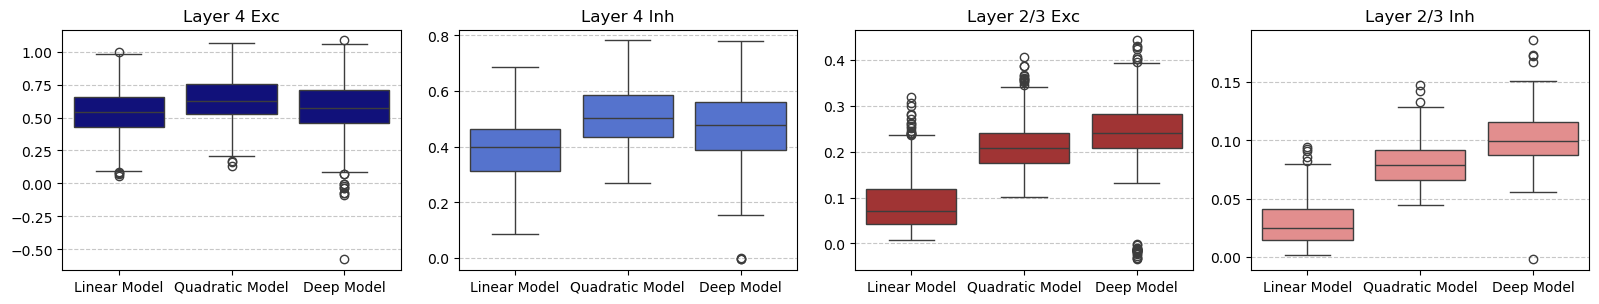

In [12]:
import seaborn as sns
colors = ['darkblue', 'royalblue', 'firebrick', 'lightcoral']
ss(1,4)
plt.subplot(1,4,1)
LL_to_plot = [GLM_LL[L4_exc_idx], GQM_LL[L4_exc_idx], LL[L4_exc_idx]]
labels = ['Linear Model', 'Quadratic Model', 'Deep Model']
sns.boxplot(data=LL_to_plot, color=colors[0])
plt.xticks(ticks=range(len(labels)), labels=labels)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.title('Layer 4 Exc')

plt.subplot(1,4,2)
LL_to_plot = [GLM_LL[L4_inh_idx], GQM_LL[L4_inh_idx], LL[L4_inh_idx]]
labels = ['Linear Model', 'Quadratic Model', 'Deep Model']
sns.boxplot(data=LL_to_plot, color=colors[1])
plt.xticks(ticks=range(len(labels)), labels=labels)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.title('Layer 4 Inh')

plt.subplot(1,4,3)
LL_to_plot = [GLM_LL[L23_exc_idx], GQM_LL[L23_exc_idx], LL[L23_exc_idx]]
labels = ['Linear Model', 'Quadratic Model', 'Deep Model']
sns.boxplot(data=LL_to_plot, color=colors[2])
plt.xticks(ticks=range(len(labels)), labels=labels)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.title('Layer 2/3 Exc')

plt.subplot(1,4,4)
LL_to_plot = [GLM_LL[L23_inh_idx], GQM_LL[L23_inh_idx], LL[L23_inh_idx]]
labels = ['Linear Model', 'Quadratic Model', 'Deep Model']
sns.boxplot(data=LL_to_plot, color=colors[3])
plt.xticks(ticks=range(len(labels)), labels=labels)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.title('Layer 2/3 Inh')

## Filters

In [52]:
filters1 = cnn.get_weights(ffnet_target=0,layer_target=1)
filters2 = cnn.get_weights(ffnet_target=0,layer_target=3)
filters3 = cnn.get_weights(ffnet_target=0,layer_target=4)
ei_mask_layer1 = deepcopy(cnn.networks[0].layers[1]._ei_mask).detach().cpu().numpy()
ei_mask_layer2 = deepcopy(cnn.networks[0].layers[3]._ei_mask).detach().cpu().numpy()
ei_mask_layer3 = deepcopy(cnn.networks[0].layers[4]._ei_mask).detach().cpu().numpy()
num_filters = [filters1.shape[3], filters2.shape[3], filters3.shape[3]]
print(filters1.shape)
print(filters2.shape)
print(filters3.shape)
print(ei_mask_layer1.shape)
print(ei_mask_layer2.shape)
print(ei_mask_layer3.shape)
print(num_filters)

(2, 19, 19, 16)
(16, 5, 5, 12)
(12, 5, 5, 8)
(96,)
(72,)
(48,)
[16, 12, 8]


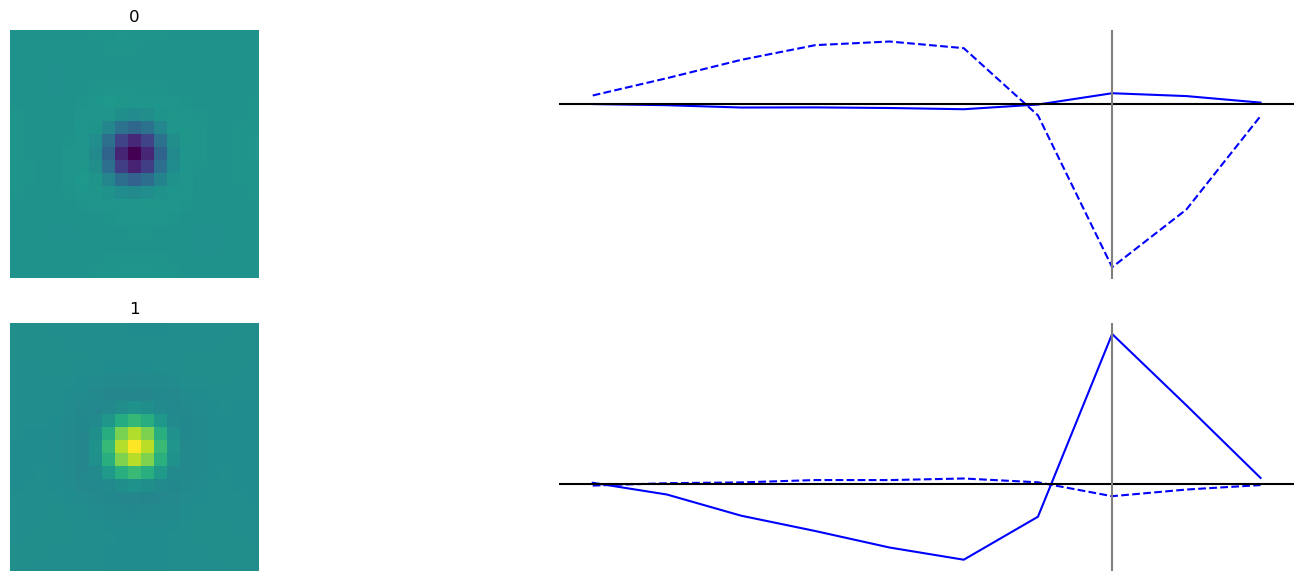

In [53]:
# LGN Layer Filters
cnn.plot_filters()

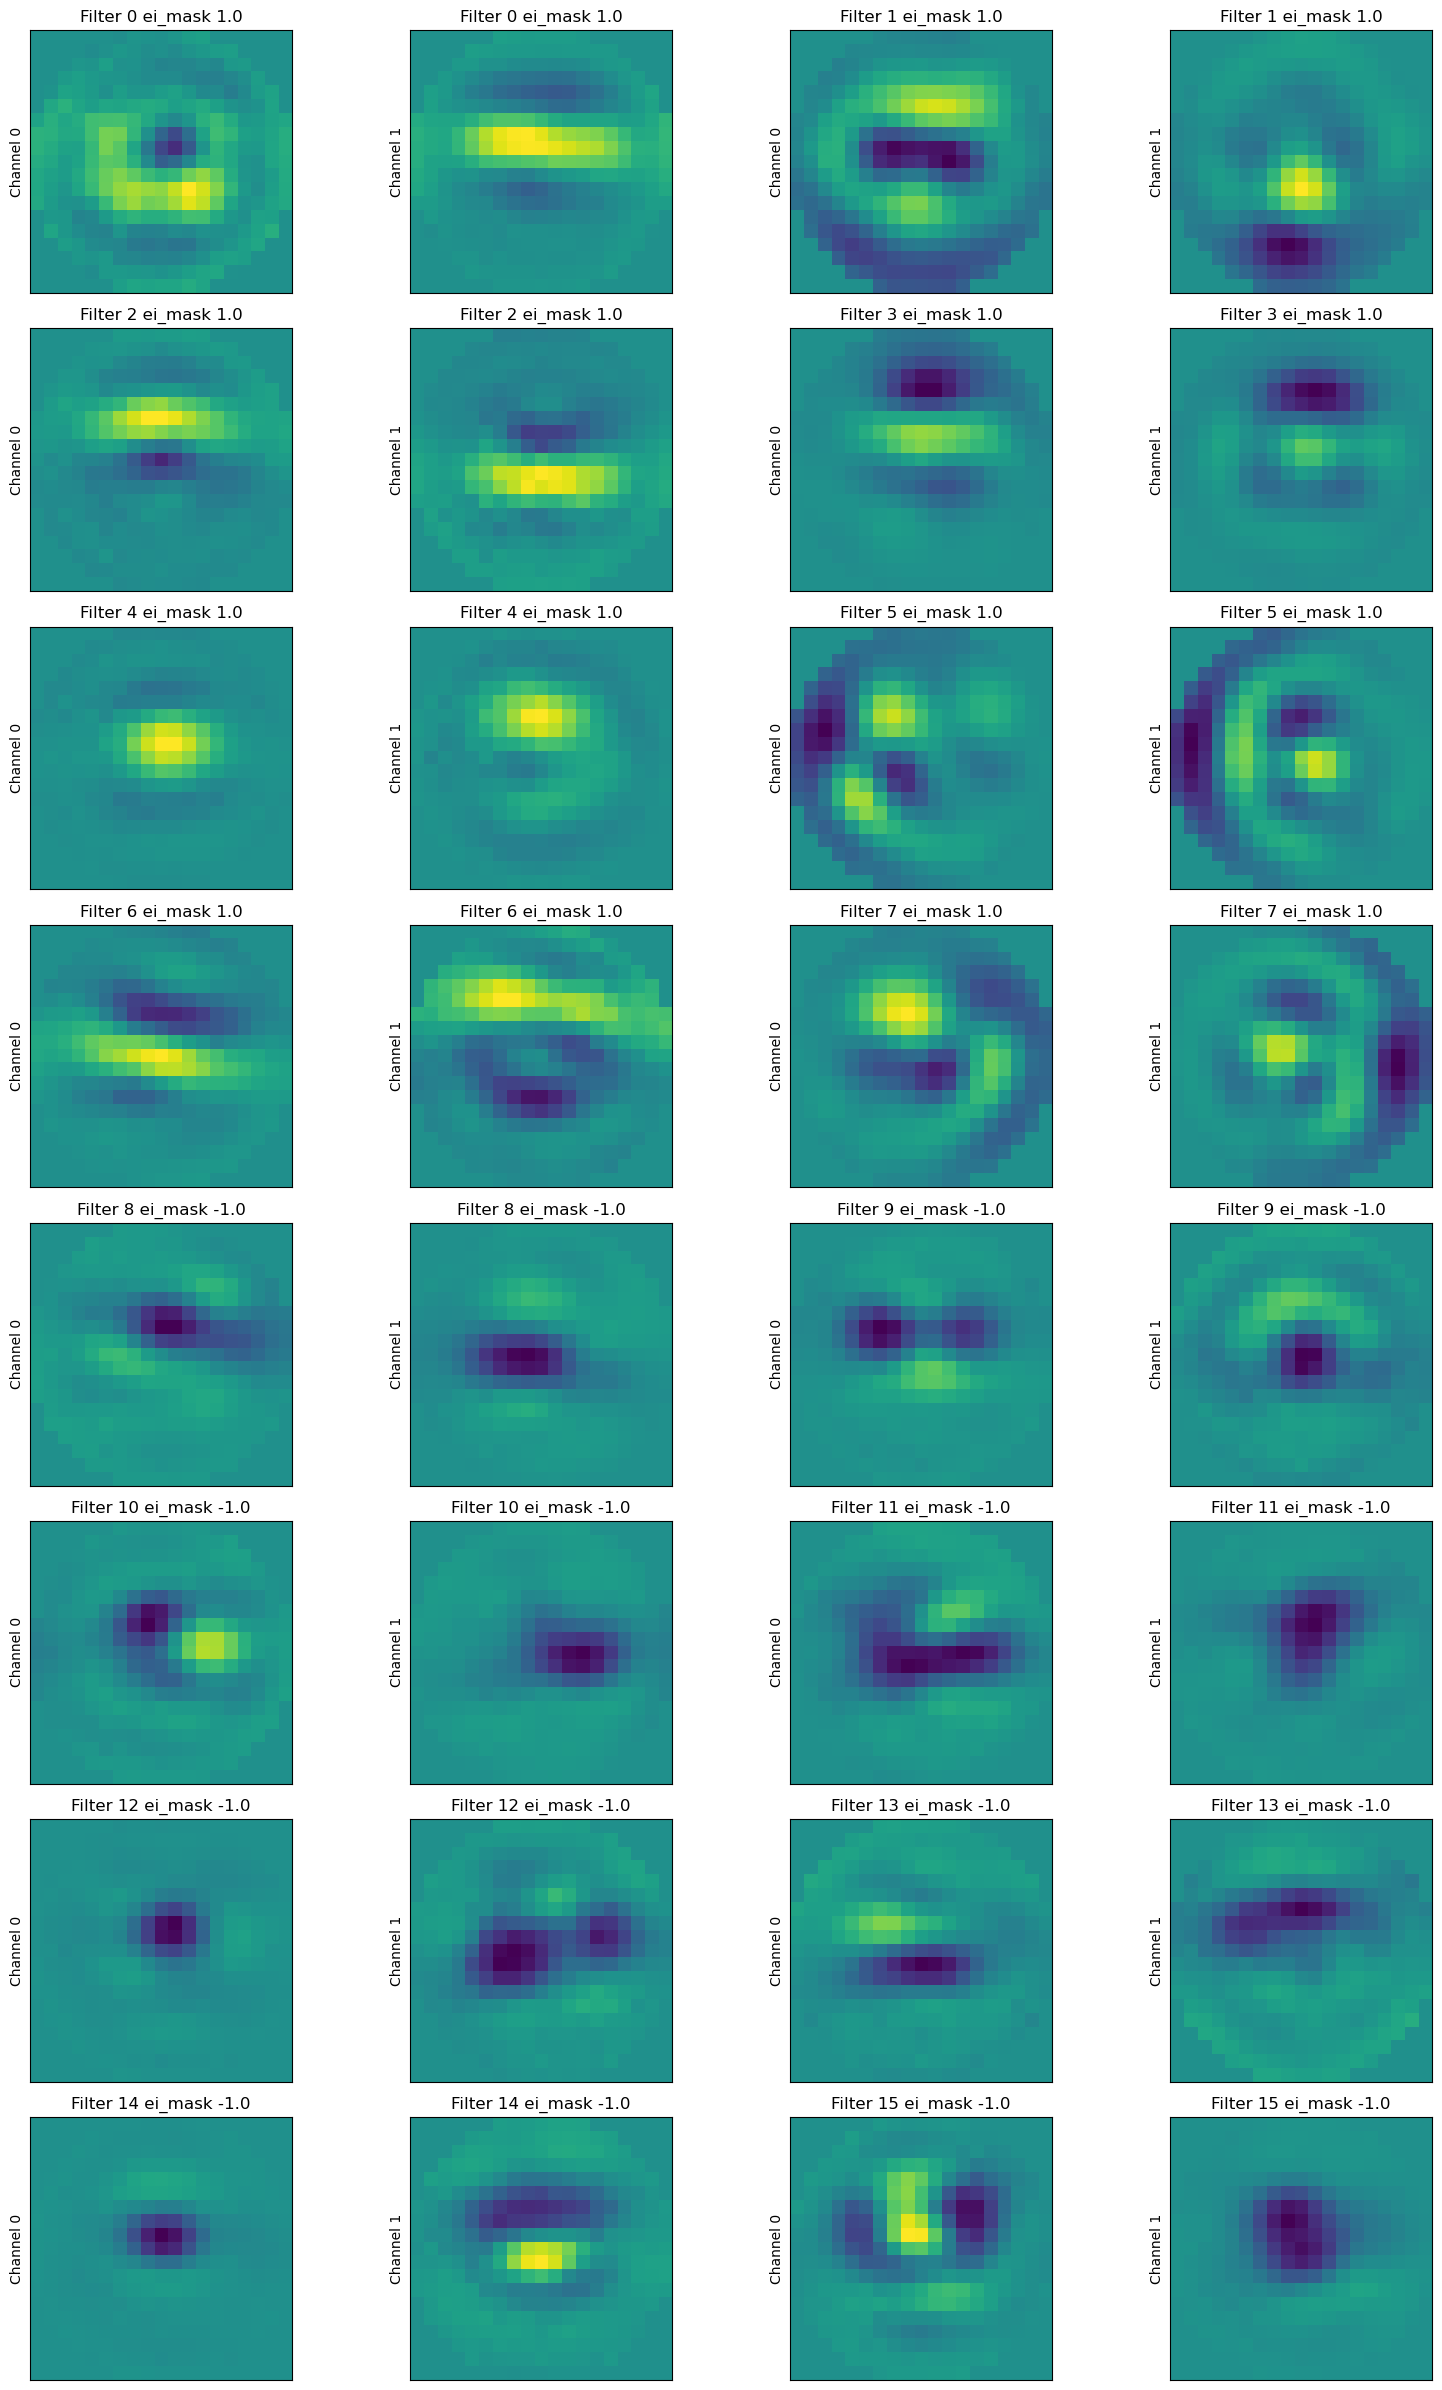

In [55]:
# Projection Layer Filters - Isabel's Way
ss(8,4)
k = 1
for i in range(16):
    plt.subplot(8,4,k)
    imagesc(filters1[0,:,:,i], balanced=True)
    plt.title('Filter '+str(i)+' ei_mask '+str(ei_mask_layer1[i]))
    plt.ylabel('Channel 0')
    plt.xticks([])
    plt.yticks([])
    k += 1

    plt.subplot(8,4,k)
    imagesc(filters1[1,:,:,i], balanced=True)
    plt.title('Filter '+str(i)+' ei_mask '+str(ei_mask_layer1[i]))
    plt.ylabel('Channel 1')
    plt.xticks([])
    plt.yticks([])
    k += 1
plt.tight_layout()
plt.show()

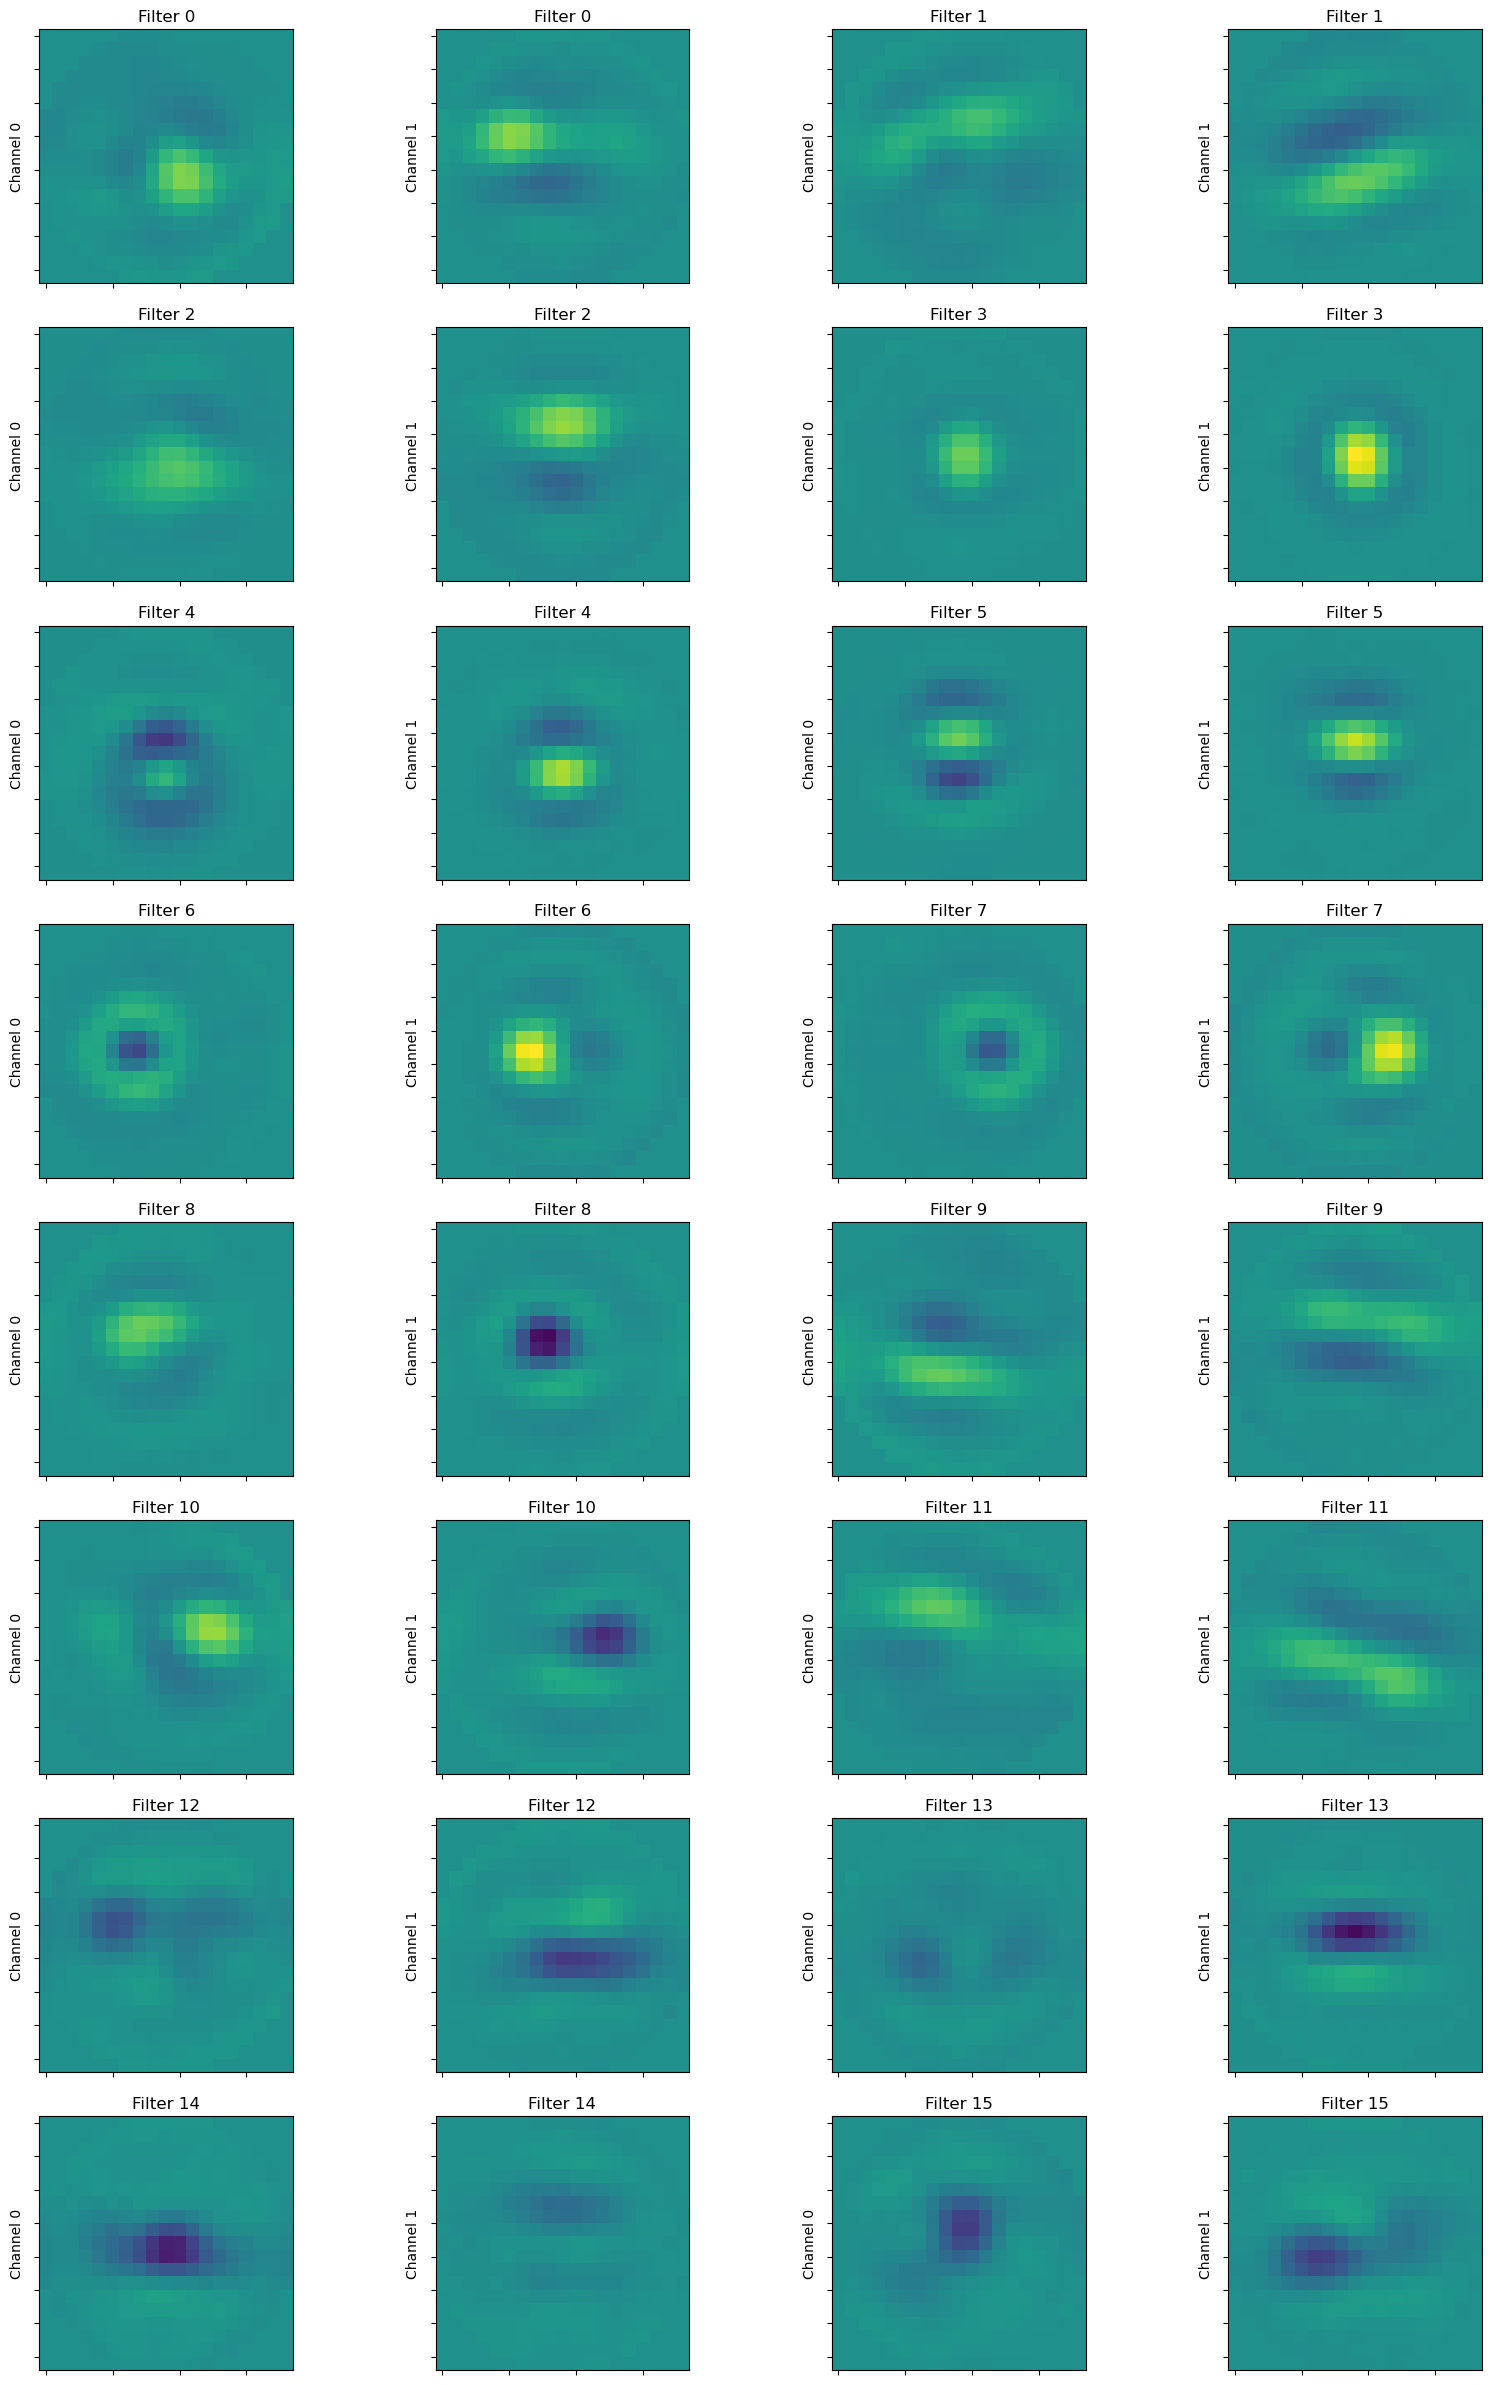

In [20]:
# Projection Layer Filters - Dan's Way
cnn.plot_filters(ffnet_target=0,layer_target=1)

## Barcodes - Complexity

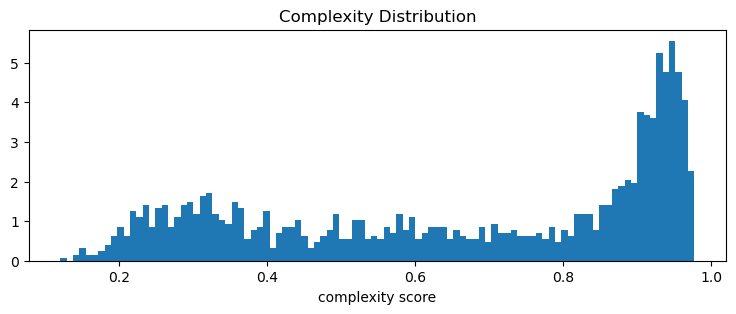

In [16]:
plt.figure(figsize=(9,3))
plt.hist(comp, bins=100, density=True)
plt.title('Complexity Distribution')
plt.xlabel('complexity score')
plt.show()

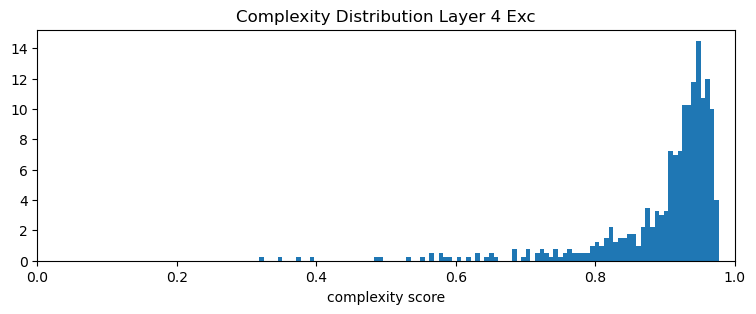

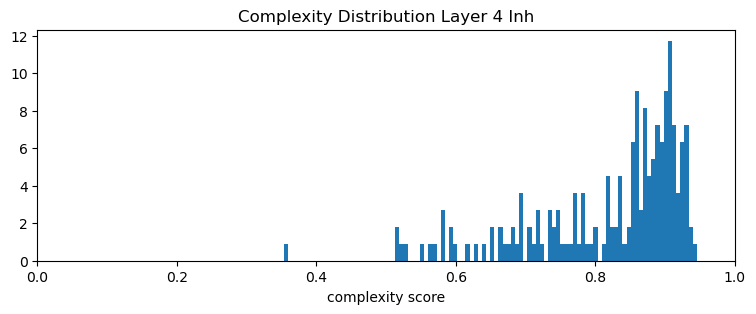

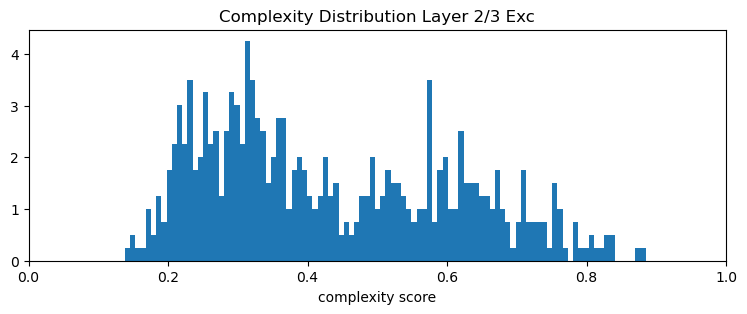

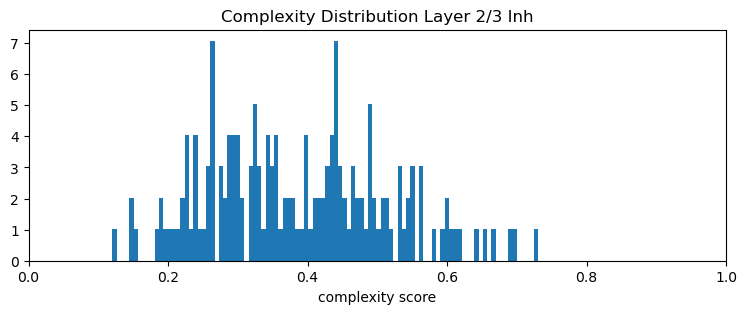

In [17]:
plt.figure(figsize=(9,3))
plt.hist(comp[L4_exc_idx], bins=100, density=True)
plt.title('Complexity Distribution Layer 4 Exc')
plt.xlabel('complexity score')
plt.xlim(0,1)
plt.show()

plt.figure(figsize=(9,3))
plt.hist(comp[L4_inh_idx], bins=100, density=True)
plt.title('Complexity Distribution Layer 4 Inh')
plt.xlabel('complexity score')
plt.xlim(0,1)
plt.show()

plt.figure(figsize=(9,3))
plt.hist(comp[L23_exc_idx], bins=100, density=True)
plt.title('Complexity Distribution Layer 2/3 Exc')
plt.xlabel('complexity score')
plt.xlim(0,1)
plt.show()

plt.figure(figsize=(9,3))
plt.hist(comp[L23_inh_idx], bins=100, density=True)
plt.title('Complexity Distribution Layer 2/3 Inh')
plt.xlabel('complexity score')
plt.xlim(0,1)
plt.show()

In [80]:
comp_sort_idx = list(np.argsort(comp))
comp_sort_idx_select = comp_sort_idx[:100]+comp_sort_idx[-100:]
print(comp[comp_sort_idx[0]])
print(comp[comp_sort_idx[-1]])

0.12008253484964371
0.9769948720932007


Text(0.5, 36.72222222222221, 'Neuron')

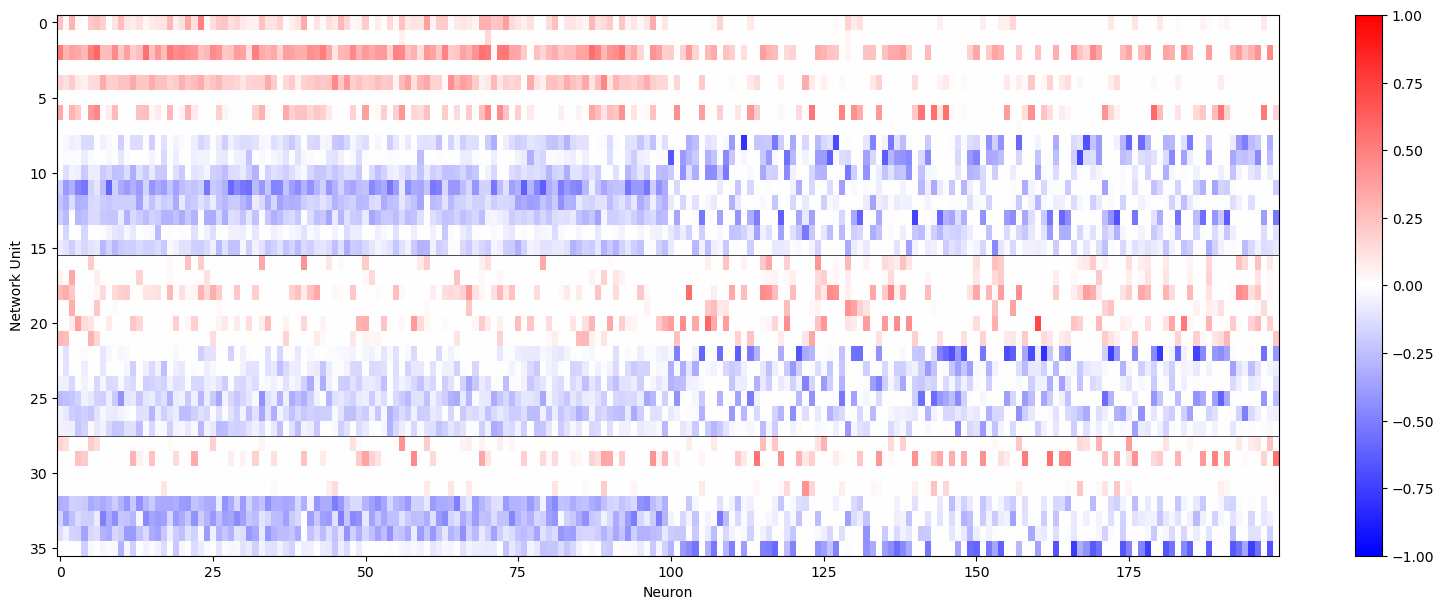

In [81]:
w = BU.get_barcode(cnn, layer_list=[1,3,4], cell_list=comp_sort_idx_select, to_plot=True, sort=False)
plt.clim(-1,1)
plt.ylabel('Network Unit')
plt.xlabel('Neuron')

(-0.5, 199.5, 199.5, -0.5)

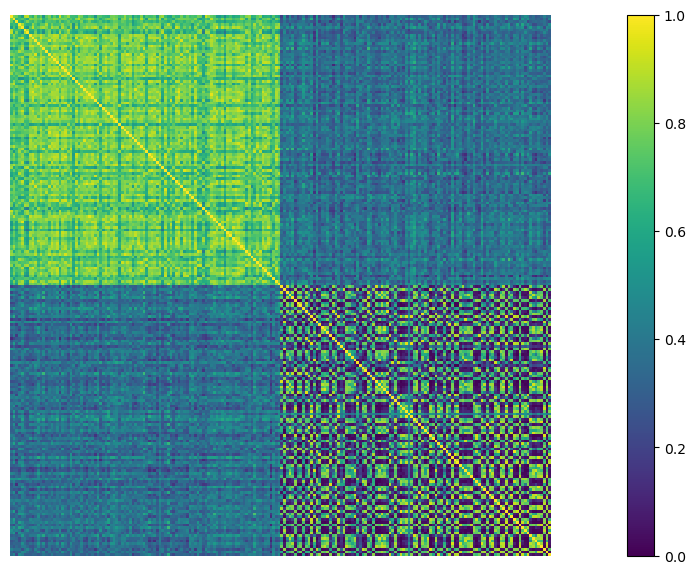

In [82]:
sim_mat = BU.get_barcode_cosine_similarity(cnn, layer_list=[1,3,4], cell_list=comp_sort_idx_select, to_plot=True, sort=False)
plt.clim(0,1)
plt.axis('off')

Text(0.5, 36.72222222222221, 'Neuron')

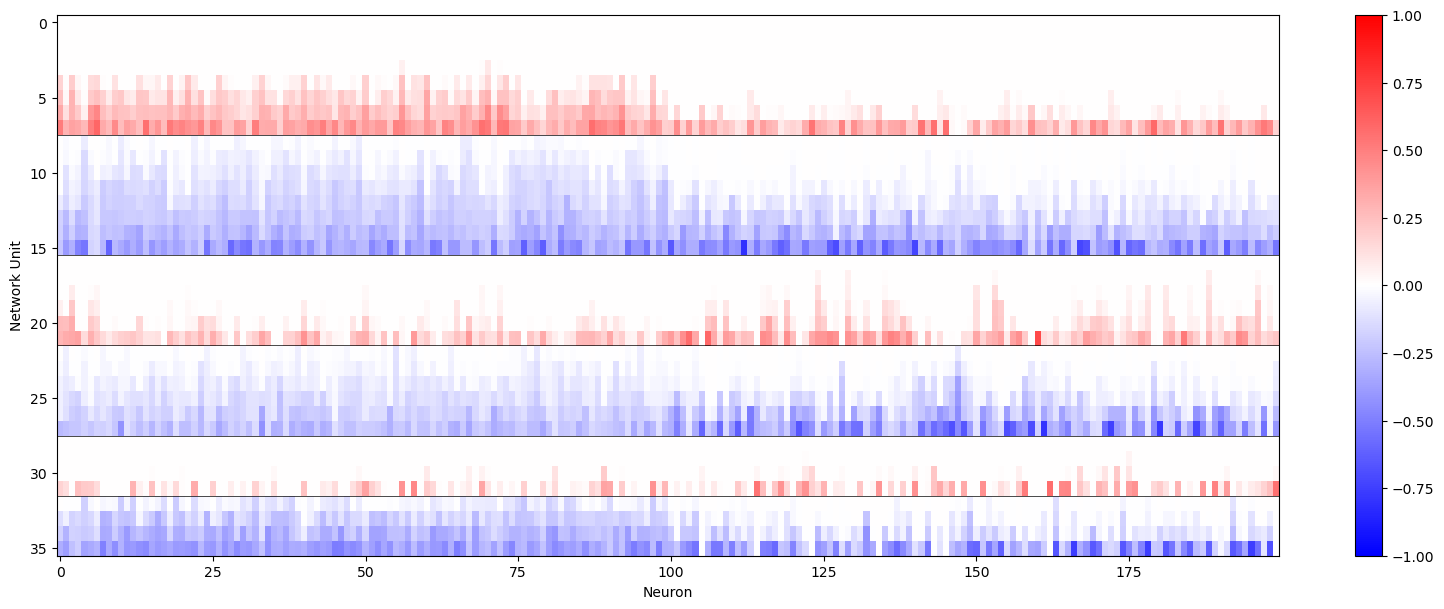

In [83]:
w_sort = BU.get_barcode(cnn, layer_list=[1,3,4], cell_list=comp_sort_idx_select, to_plot=True, sort=True)
plt.clim(-1,1)
plt.ylabel('Network Unit')
plt.xlabel('Neuron')

(-0.5, 199.5, 199.5, -0.5)

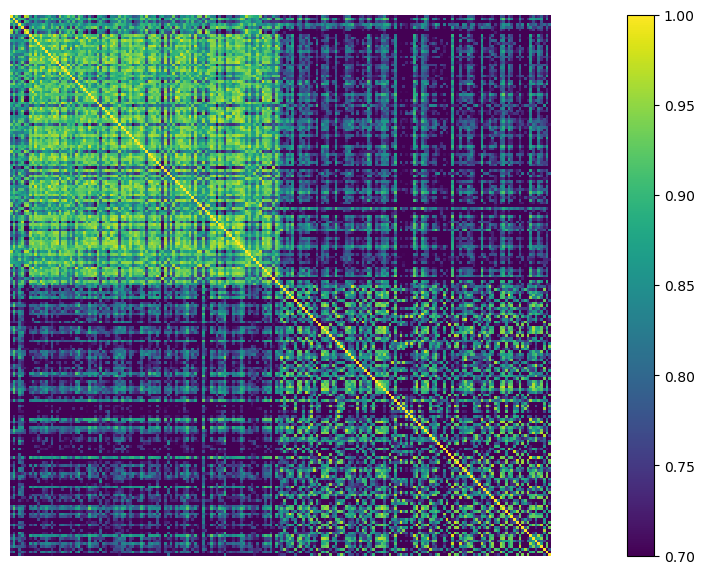

In [84]:
sim_mat_sort = BU.get_barcode_cosine_similarity(cnn, layer_list=[1,3,4], cell_list=comp_sort_idx_select, to_plot=True, sort=True)
plt.clim(0.7,1)
plt.axis('off')

## Barcode - By Cell - Filter Based

Text(0.5, 36.72222222222221, 'Neuron')

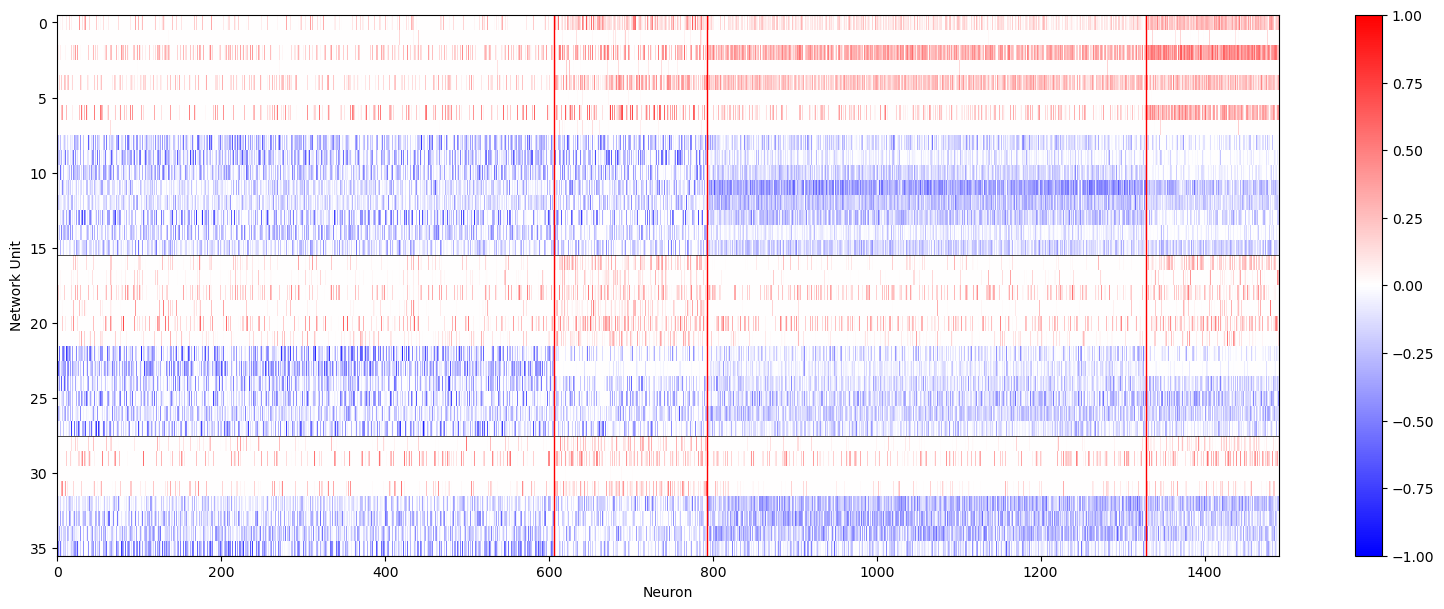

In [60]:
w = BU.get_barcode(cnn, layer_list=[1,3,4], to_plot=True, sort=False)
plt.axvline(x=L4_exc_idx[-1], color='red', lw=1)
plt.axvline(x=L4_inh_idx[-1], color='red', lw=1)
plt.axvline(x=L23_exc_idx[-1], color='red', lw=1)
plt.clim(-1,1)
plt.ylabel('Network Unit')
plt.xlabel('Neuron')

(-0.5, 1490.5, 1490.5, -0.5)

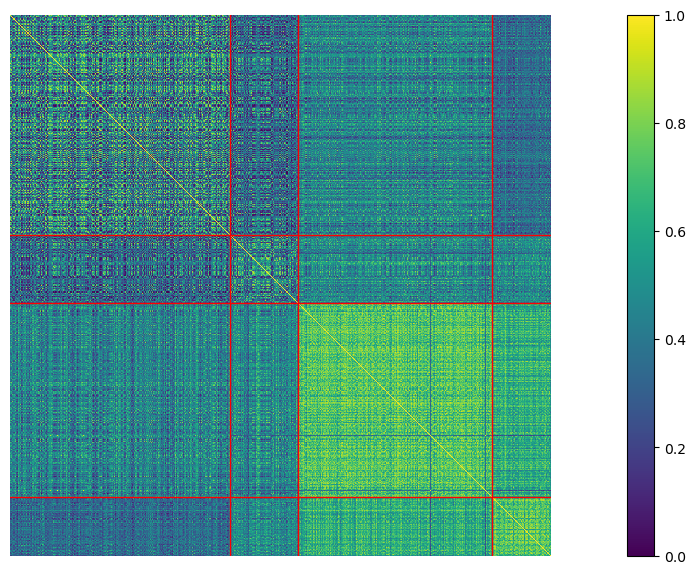

In [61]:
sim_mat = BU.get_barcode_cosine_similarity(cnn, layer_list=[1,3,4],to_plot=True, sort=False)
plt.clim(0,1)
plt.axvline(x=L4_exc_idx[-1], color='red', lw=1)
plt.axhline(y=L4_exc_idx[-1], color='red', lw=1)
plt.axvline(x=L4_inh_idx[-1], color='red', lw=1)
plt.axhline(y=L4_inh_idx[-1], color='red', lw=1)
plt.axvline(x=L23_exc_idx[-1], color='red', lw=1)
plt.axhline(y=L23_exc_idx[-1], color='red', lw=1)
plt.axis('off')

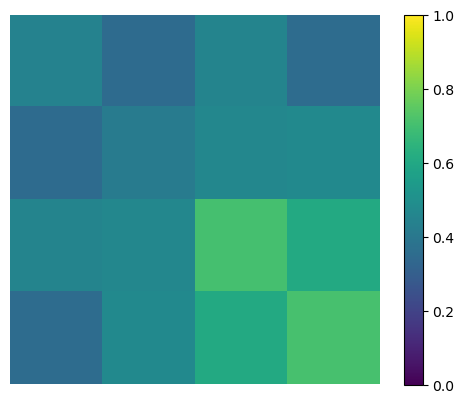

In [62]:
avg_sim, _, _, sim_diff = BU.avg_sim_mat(cnn, int_key, layer_list=[1,3,4], sort=False)
imagesc(avg_sim)
plt.axis('off')
plt.colorbar()
plt.clim([0,1])
plt.show()

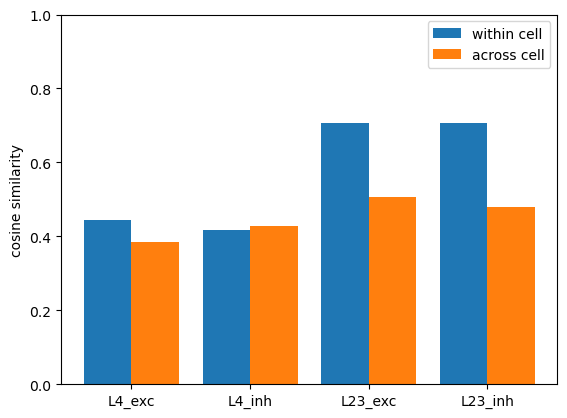

In [63]:
BU.sim_vs_diff_bar_plot(cnn, int_key, labels_key=key_dict, layer_list=[1,3,4], sort=False)

## Barcode - By Cell - Connectivity Based

Text(0.5, 36.72222222222221, 'Neuron')

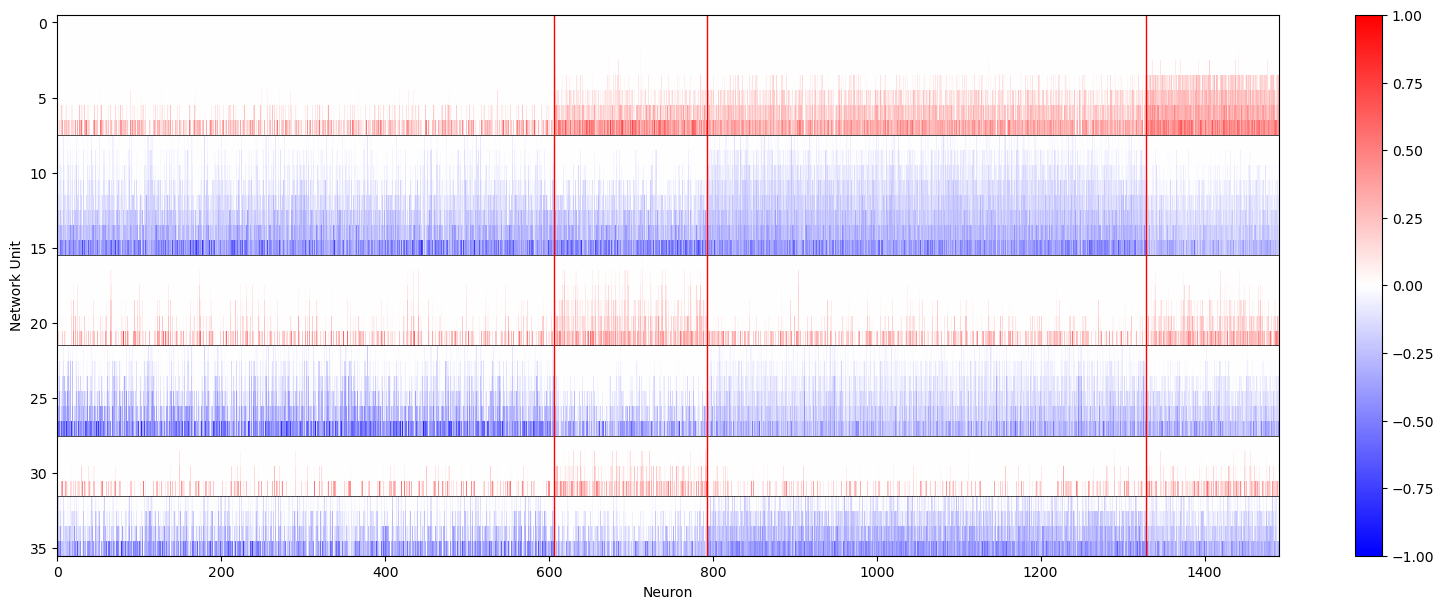

In [64]:
w = BU.get_barcode(cnn, layer_list=[1,3,4], to_plot=True, sort=True)
plt.axvline(x=L4_exc_idx[-1], color='red', lw=1)
plt.axvline(x=L4_inh_idx[-1], color='red', lw=1)
plt.axvline(x=L23_exc_idx[-1], color='red', lw=1)
plt.clim(-1,1)
plt.ylabel('Network Unit')
plt.xlabel('Neuron')

(-0.5, 1490.5, 1490.5, -0.5)

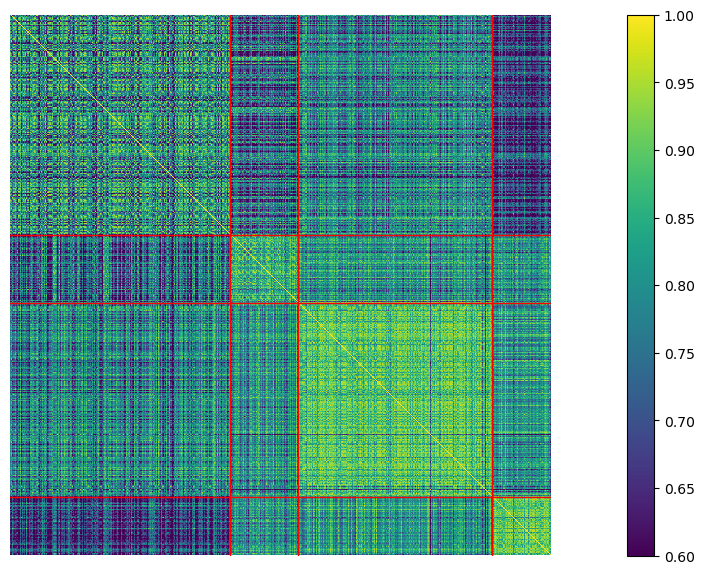

In [65]:
sim_mat = BU.get_barcode_cosine_similarity(cnn, layer_list=[1,3,4],to_plot=True, sort=True)
plt.clim(0.6,1)
plt.axvline(x=L4_exc_idx[-1], color='red', lw=1)
plt.axhline(y=L4_exc_idx[-1], color='red', lw=1)
plt.axvline(x=L4_inh_idx[-1], color='red', lw=1)
plt.axhline(y=L4_inh_idx[-1], color='red', lw=1)
plt.axvline(x=L23_exc_idx[-1], color='red', lw=1)
plt.axhline(y=L23_exc_idx[-1], color='red', lw=1)
plt.axis('off')

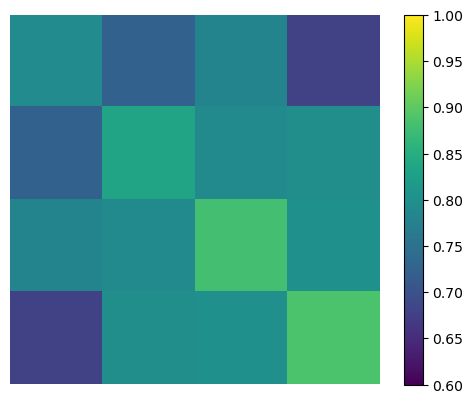

In [66]:
avg_sim_sort, _, _, sim_diff_sort = BU.avg_sim_mat(cnn, int_key, layer_list=[1,3,4], sort=True)
imagesc(avg_sim_sort)
plt.axis('off')
plt.colorbar()
plt.clim(0.6,1)
plt.show()

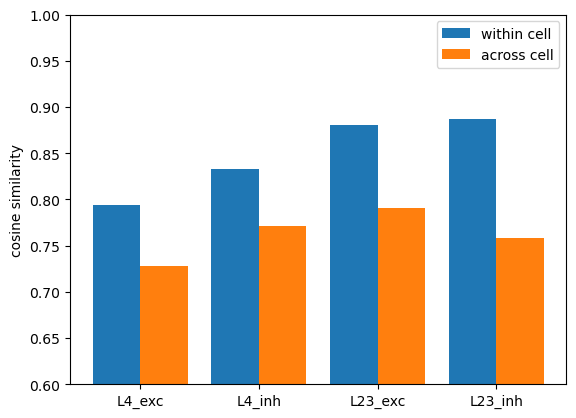

In [67]:
BU.sim_vs_diff_bar_plot(cnn, int_key, labels_key=key_dict, layer_list=[1,3,4], sort=True, ymin=0.6)

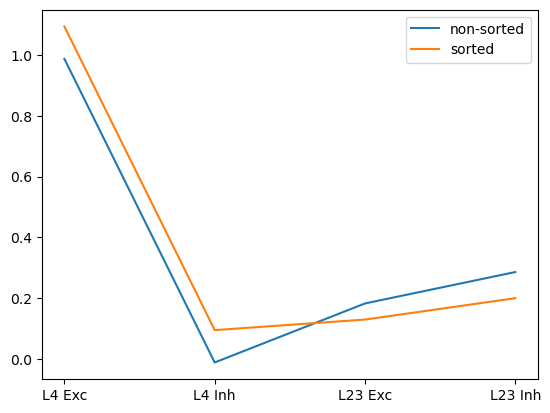

In [31]:
plt.plot(sim_diff, label='non-sorted')
plt.plot(sim_diff_sort, label='sorted')
plt.xticks(np.arange(4), ['L4 Exc', 'L4 Inh', 'L23 Exc', 'L23 Inh'])
plt.legend()
plt.show()

## Logistic Regression Analysis

## Comparing Models

In [69]:
model_name_list = ['0325_updated_lossL', '0326_updated_lossL', '0327_updated_lossL', '0327_updated_lossL2', '0327_updated_lossL3', '0328_updated_lossL']
model_list = []
for i in range(len(model_name_list)):
    cnn = NDN.load_model('models/'+model_name_list[i]+'.ndn')
    cnn.block_sample = True
    model_list.append(cnn)

In [70]:
LL_list = []
for i in range(len(model_name_list)):
    cnn = model_list[i]
    LL_list.append(cnn.eval_models(data, data_inds=data.val_blks, device=device, batch_size=1, null_adjusted=True))

Eval models: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 102/102 [00:24<00:00,  4.21it/s]


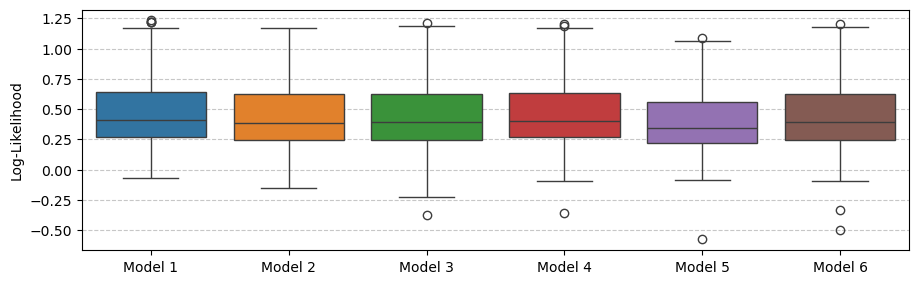

In [85]:
subplot_setup(1,1,3,9)
labels = ['Model '+str(i+1) for i in range(len(model_name_list))]
sns.boxplot(data=LL_list)
plt.xticks(ticks=range(len(labels)), labels=labels)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.ylabel('Log-Likelihood')
plt.show()

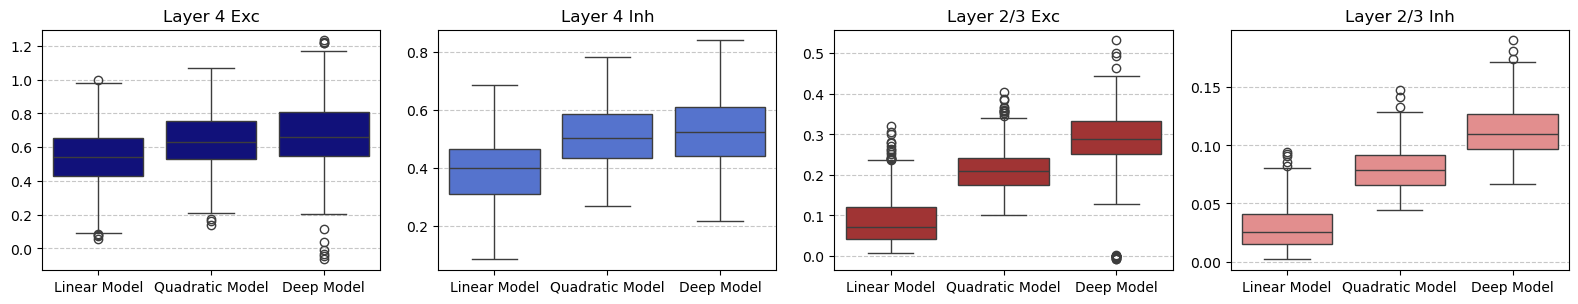

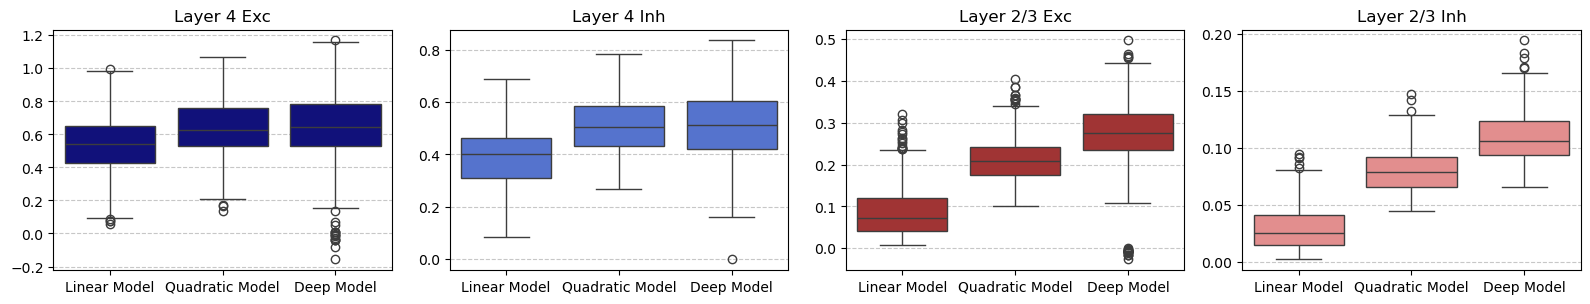

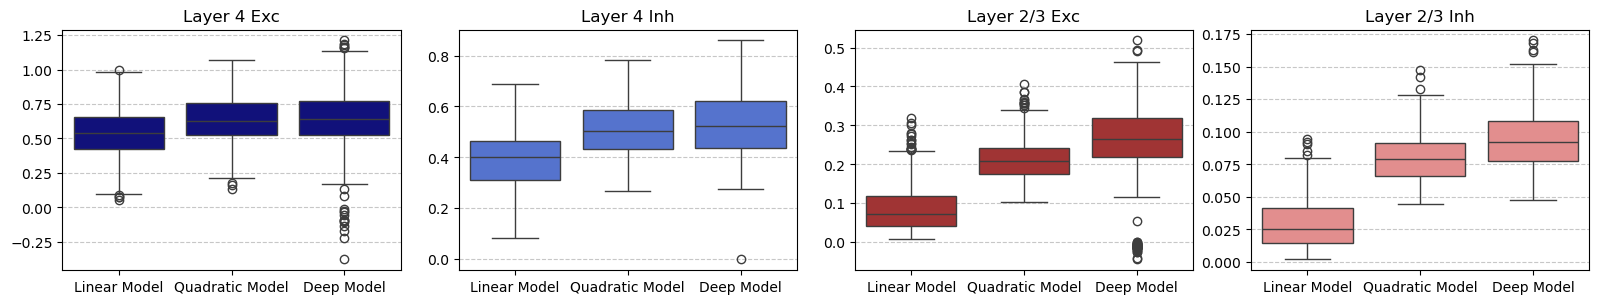

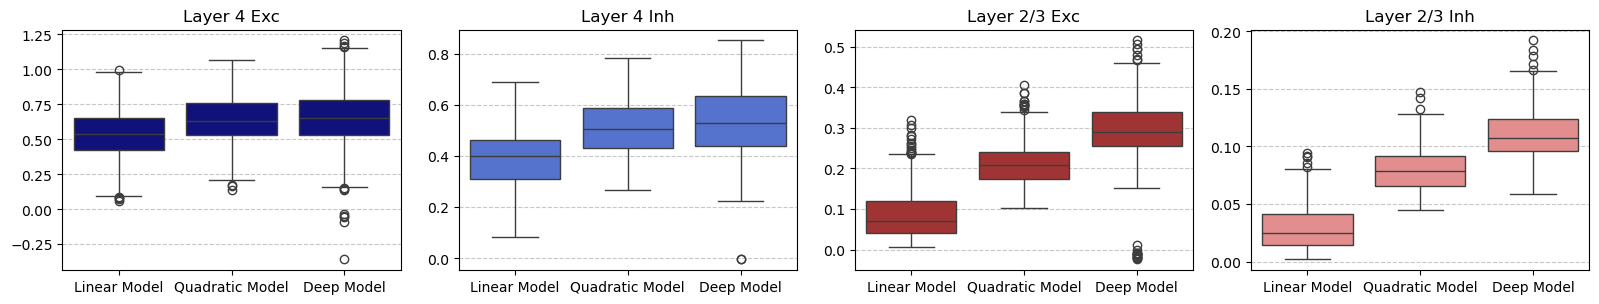

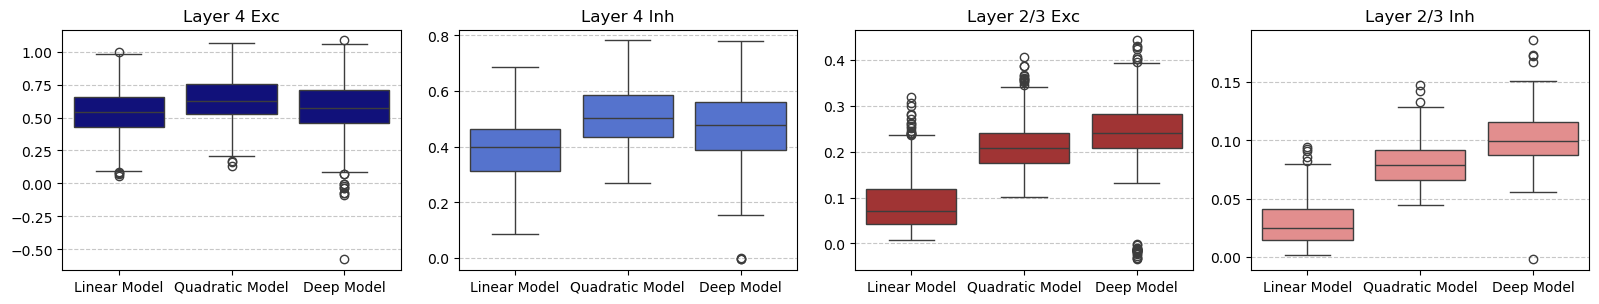

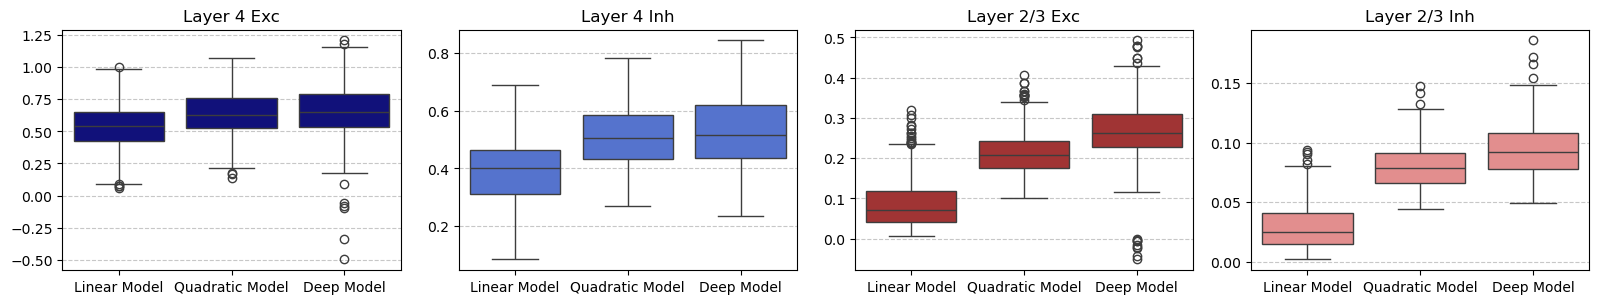

In [86]:
colors = ['darkblue', 'royalblue', 'firebrick', 'lightcoral']
labels = ['Linear Model', 'Quadratic Model', 'Deep Model']
for i in range(len(model_name_list)):
    LL = LL_list[i]
    ss(1,4)
    plt.subplot(1,4,1)
    LL_to_plot = [GLM_LL[L4_exc_idx], GQM_LL[L4_exc_idx], LL[L4_exc_idx]]
    sns.boxplot(data=LL_to_plot, color=colors[0])
    plt.xticks(ticks=range(len(labels)), labels=labels)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.title('Layer 4 Exc')
    
    plt.subplot(1,4,2)
    LL_to_plot = [GLM_LL[L4_inh_idx], GQM_LL[L4_inh_idx], LL[L4_inh_idx]]
    sns.boxplot(data=LL_to_plot, color=colors[1])
    plt.xticks(ticks=range(len(labels)), labels=labels)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.title('Layer 4 Inh')
    
    plt.subplot(1,4,3)
    LL_to_plot = [GLM_LL[L23_exc_idx], GQM_LL[L23_exc_idx], LL[L23_exc_idx]]
    sns.boxplot(data=LL_to_plot, color=colors[2])
    plt.xticks(ticks=range(len(labels)), labels=labels)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.title('Layer 2/3 Exc')

    plt.subplot(1,4,4)
    LL_to_plot = [GLM_LL[L23_inh_idx], GQM_LL[L23_inh_idx], LL[L23_inh_idx]]
    sns.boxplot(data=LL_to_plot, color=colors[3])
    plt.xticks(ticks=range(len(labels)), labels=labels)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.title('Layer 2/3 Inh')
    plt.show()

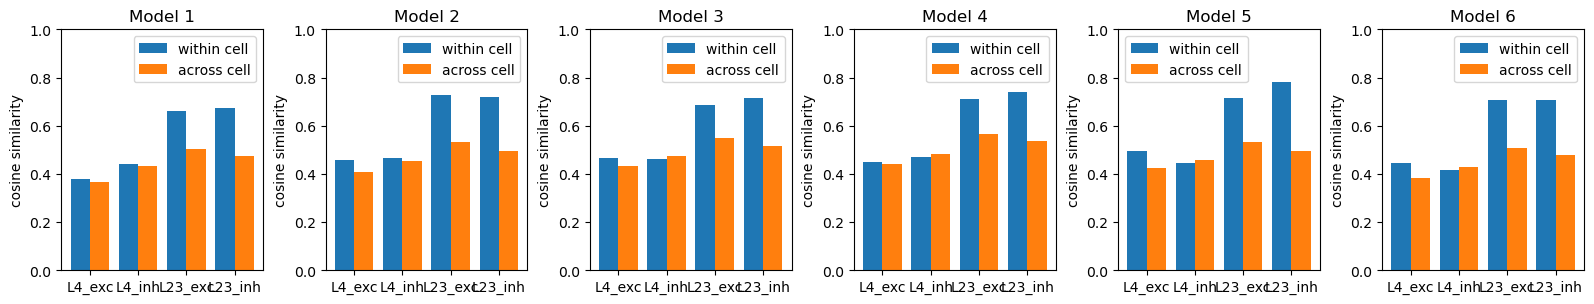

In [87]:
ss(1,len(model_name_list))
for i in range(len(model_name_list)):
    cnn = model_list[i]
    plt.subplot(1,len(model_name_list),i+1)
    BU.sim_vs_diff_bar_plot(cnn, int_key, labels_key=key_dict, layer_list=[1,3,4], sort=False)
    plt.title('Model '+str(i+1))
plt.show()

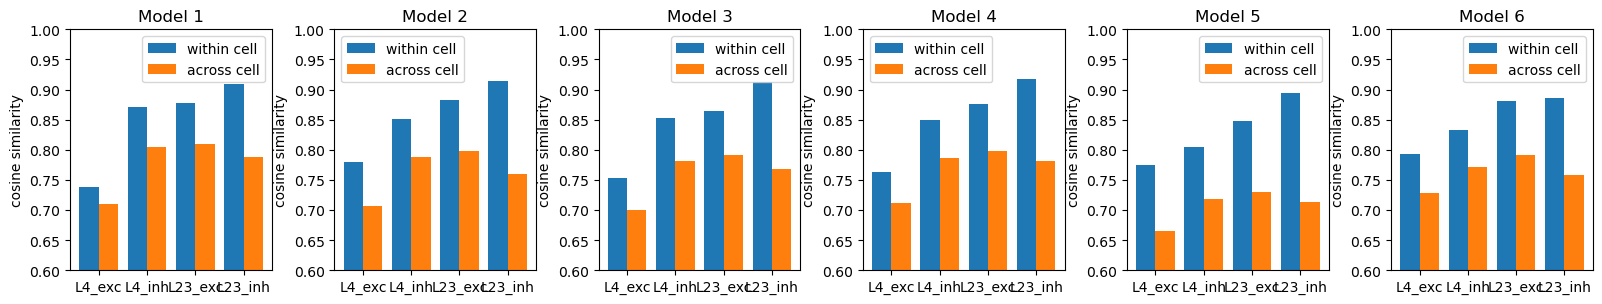

In [88]:
ss(1,len(model_name_list))
for i in range(len(model_name_list)):
    cnn = model_list[i]
    plt.subplot(1,len(model_name_list),i+1)
    BU.sim_vs_diff_bar_plot(cnn, int_key, labels_key=key_dict, layer_list=[1,3,4], sort=True, ymin=0.6)
    plt.title('Model '+str(i+1))
plt.show()

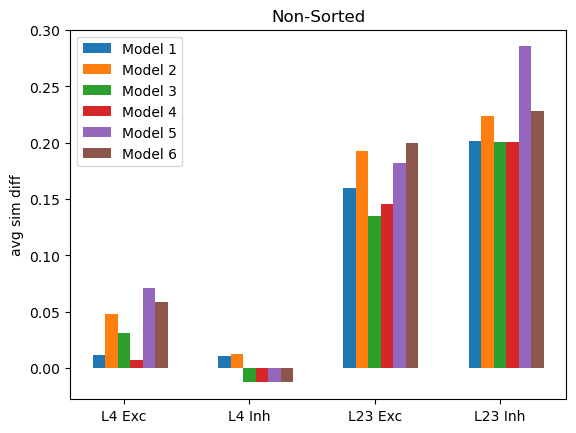

In [89]:
sim_diff_list = []
for i in range(len(model_name_list)):
    cnn = model_list[i]
    _, _, _, sim_diff = BU.avg_sim_mat(cnn, int_key, layer_list=[1,3,4], sort=False)
    sim_diff_list.append(sim_diff)

offset_list = [-0.2,-0.1,0,0.1,0.2,0.3]
labels = ['L4 Exc', 'L4 Inh', 'L23 Exc', 'L23 Inh']
for i in range(len(model_name_list)):
    plt.bar(np.arange(4)+offset_list[i], sim_diff_list[i], label='Model '+str(i+1), width=0.1)
plt.xticks(ticks=range(len(labels)), labels=labels)
plt.ylabel('avg sim diff')
plt.title('Non-Sorted')
plt.legend()
plt.show()

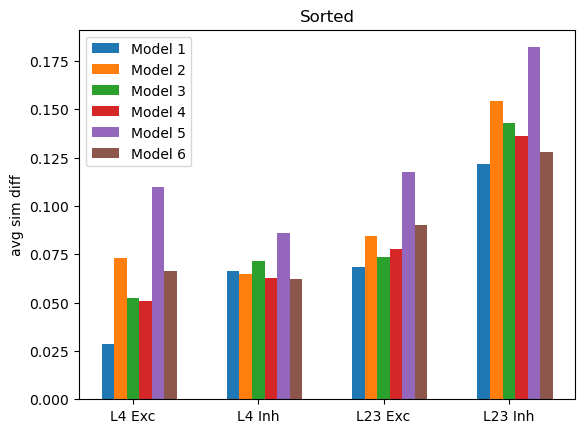

In [90]:
sim_diff_sort_list = []
for i in range(len(model_name_list)):
    cnn = model_list[i]
    _, _, _, sim_diff = BU.avg_sim_mat(cnn, int_key, layer_list=[1,3,4], sort=True)
    sim_diff_sort_list.append(sim_diff)

offset_list = [-0.2,-0.1,0,0.1,0.2,0.3]
labels = ['L4 Exc', 'L4 Inh', 'L23 Exc', 'L23 Inh']
for i in range(len(model_name_list)):
    plt.bar(np.arange(4)+offset_list[i], sim_diff_sort_list[i], label='Model '+str(i+1), width=0.1)
plt.xticks(ticks=range(len(labels)), labels=labels)
plt.ylabel('avg sim diff')
plt.title('Sorted')
plt.legend()
plt.show()